In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#from google.colab import drive
#drive.flush_and_unmount()

In [ ]:
%cd '/content/drive/MyDrive/BOED/sOED-loc_finding'

/content/drive/MyDrive/BOED/sOED-loc_finding


In [ ]:
!python3 -m pip install -U pip
!pip install -U setuptools setuptools_scm pep517
!pip install -U emcee

     |████████████████████████████████| 2.1 MB 8.6 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.2 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 KB 3.5 MB/s eta 0:00:00


In [ ]:
%load_ext autoreload
%autoreload 2

import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(os.path.dirname(current_dir))
sys.path.insert(0, parent_dir) 

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from sOED import SOED
from sOED import PGsOED
from sOED.utils import *

def loc_finding_model(stage, theta, d, xp=None):
    """
    Source location finding model

    Parameters
    ----------
    stage : int
        The stage index of the experiment. Has no practical effect here.
    theta : np.ndarray of size (n_sample or 1, n_param)
        The value of unknown linear model parameters.
    d : np.ndarray of size (n_sample or 1, n_design)
        The design variable.
    xp : np.ndarray of size (n_sample or 1, n_phys_state), 
         optional(default=None)
        The physical state. Has no practical effect here.

    Returns
    -------
    numpy.ndarray of size (n_sample, n_obs)
        The output of the location finding model.
    """
    # set model hyperparameters
    b = 1e-1
    m = 1e-4
    n_sample = max(len(theta), len(d), len(xp))

    # calculate mean observation
    y = b + np.mean(1/(m + (theta - d)**2), axis=1)
    y = np.reshape(y, (n_sample, n_obs))
    return y

# this function is left over from the original implementation, but does not
# affect the model when the sPCE reward is used.
def reward_fun(stage, xb, xp, d, y):
    """
    Non-KL-divergence based reward function g_k(x_k, d_k, y_k)
    
    Parameters
    ----------
    stage : int
        The stage index of the experiment.
    xb : numpy.ndarray of size (n_grid ** n_param, n_param + 1)
        Grid discritization of the belief state.
    xp : np.ndarray of size (n_phys_state)
        The physical state.
    d : np.ndarray of size (n_design)
        The design variable.
    y : np.ndarray of size (n_obs)
        The observation.

    Returns
    -------
    A float which is the reward.
    """
    if stage < n_stage:
        return 0
    else:
        return 0

# there is no need to specify a physical state function for source location
# finding, so we've set it to always be equal to the experiment design.   
def phys_state_fun(xp, stage, d, y):
    """
    Physical state transition function.
    x_{k+1,p} = phys_state_fun(x_{k,p}, d_k, y_k).
    
    Parameters
    ----------
    xp : np.ndarray of size (n_sample or 1, n_phys_state)
        The old physical state before conducting stage-th 
        experiement.
    stage : int
        The stage index of the experiment.
    d : np.ndarray of size (n_sample or 1, n_design)
        The design variables at stage-th experiment.
    y : np.ndarray of size (n_sample or 1, n_obs)
        The observations at stage-th expriments.
    
    Returns
    -------
    A numpy.ndarray of size (n_sample, n_xp)
    """
    return d

In [ ]:
n_stage = 30 # Number of stages. 
n_param = 1 # Number of parameters. 
n_design = 1 # Number of design variables. 
n_obs = 1 # Number of observations. 

prior_type = "uniform" # "normal" for normal dist, "uniform" for uniform dist.
prior_loc = -3 # mean for normal, lower bound for uniform.
prior_scale = 6 # std for normal, range for uniform.
prior_info = [(prior_type, prior_loc, prior_scale)]

design_bounds = [(-3, 3)] # lower and upper bounds of design variables. 

# Noise if following N(noise_loc, noise_base_scale + noise_ratio_scale * abs(G)). 
noise_loc = 0
noise_base_scale = 0.5
noise_ratio_scale = 0
noise_info = [(noise_loc, noise_base_scale, noise_ratio_scale),]

# Physical state info.
n_phys_state = 1
init_phys_state = np.array([0])
phys_state_info = (n_phys_state, init_phys_state, phys_state_fun)

# Number of grid points on each dimension of parameter space to store PDFs.
n_grid = 300

# Method to sample posterior samples, could be "Rejection" or "MCMC", default
# is "MCMC".
# In practice this is not used in this implementation. 
post_rvs_method = "Rejection" 

# Random state could be eith an integer or None.
random_state = 2021

In [ ]:
soed = PGsOED(model_fun=loc_finding_model,
              n_stage=n_stage,
              n_param=n_param,
              n_design=n_design,
              n_obs=n_obs,
              prior_info=prior_info,
              design_bounds=design_bounds,
              noise_info=noise_info,
              reward_fun="sPCE",
              phys_state_info=phys_state_info,
              n_grid=n_grid,
              post_rvs_method=post_rvs_method,
              random_state=random_state,
              actor_dimns=[80, 80],
              critic_dimns=[80, 80])

In [ ]:
soed.initialize()
actor_optimizer = optim.Adam(soed.actor_net.parameters(), lr=0.01)
actor_lr_scheduler = optim.lr_scheduler.ExponentialLR(actor_optimizer, gamma=0.98)

n_critic_update = 100
critic_optimizer = optim.Adam(soed.critic_net.parameters(), lr=0.01)
critic_lr_scheduler = optim.lr_scheduler.ExponentialLR(critic_optimizer, gamma=0.98)

In [ ]:
soed.soed(n_update=30,
          n_traj=2000,
          actor_optimizer=actor_optimizer,
          actor_lr_scheduler=actor_lr_scheduler,
          n_critic_update=n_critic_update,
          critic_optimizer=critic_optimizer,
          critic_lr_scheduler=critic_lr_scheduler,
          design_noise_scale=0, 
          design_noise_decay=0.99)

Update Level 0
******************************
Averaged total reward:  2.053
Update Level 1
******************************
Averaged total reward:  2.201
Update Level 2
******************************
Averaged total reward:  2.282
Update Level 3
******************************
Averaged total reward:  2.08
Update Level 4
******************************
Averaged total reward:  1.961
Update Level 5
******************************
Averaged total reward:  1.831
Update Level 6
******************************
Averaged total reward:  1.84
Update Level 7
******************************
Averaged total reward:  1.783
Update Level 8
******************************
Averaged total reward:  1.794
Update Level 9
******************************
Averaged total reward:  1.789
Update Level 10
******************************
Averaged total reward:  1.767
Update Level 11
******************************
Averaged total reward:  1.792
Update Level 12
******************************
Averaged total reward:  1.792
Update Leve

In [ ]:
averaged_reward, thetas, dcs_hist, ds_hist, ys_hist, xbs, xps_hist, rewards_hist =soed.asses(2000, return_all=True)
print(np.std(rewards_hist.sum(-1)))

******************************
Averaged total reward:  1.887
1.0827762333922635


In [ ]:
print("Theta sample:" + str(thetas[0]))
dc = np.reshape(dcs_hist[0], n_stage)
print("Corresponding decision history:" + str(dc))

Theta sample:[2.10352062]
Corresponding decision history:[-1.32830763 -2.93135667 -2.99974656 -2.99999905 -3.         -3.
 -3.         -3.         -3.         -3.         -3.         -3.
 -3.         -3.         -3.         -3.         -3.         -3.
 -3.         -3.         -3.         -3.         -3.         -3.
 -3.         -3.         -3.         -3.         -3.         -3.        ]


Text(0, 0.5, 'Design')

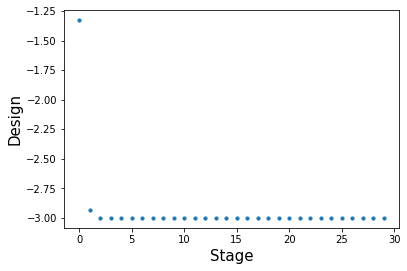

In [ ]:
plt.scatter(range(n_stage), dc, s=10)
plt.xlabel('Stage', fontsize=15)
plt.ylabel('Design', fontsize=15)